<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Link-Prediction-using-Graph-Neural-Networks" data-toc-modified-id="Link-Prediction-using-Graph-Neural-Networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Link Prediction using Graph Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Overview-of-Link-Prediction-with-GNN" data-toc-modified-id="Overview-of-Link-Prediction-with-GNN-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Overview of Link Prediction with GNN</a></span></li><li><span><a href="#Loading-graph-and-features" data-toc-modified-id="Loading-graph-and-features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loading graph and features</a></span></li><li><span><a href="#Prepare-training-and-testing-sets" data-toc-modified-id="Prepare-training-and-testing-sets-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prepare training and testing sets</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-1.3.0.1"><span class="toc-item-num">1.3.0.1&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li><li><span><a href="#Define-a-GraphSAGE-model" data-toc-modified-id="Define-a-GraphSAGE-model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define a GraphSAGE model</a></span></li><li><span><a href="#Positive-graph,-negative-graph,-and-apply_edges" data-toc-modified-id="Positive-graph,-negative-graph,-and-apply_edges-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Positive graph, negative graph, and <code>apply_edges</code></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-1.5.0.1"><span class="toc-item-num">1.5.0.1&nbsp;&nbsp;</span>Note</a></span></li><li><span><a href="#Note" data-toc-modified-id="Note-1.5.0.2"><span class="toc-item-num">1.5.0.2&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li><li><span><a href="#Training-loop" data-toc-modified-id="Training-loop-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Training loop</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-1.6.0.1"><span class="toc-item-num">1.6.0.1&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Read-Kegg-reactions" data-toc-modified-id="Read-Kegg-reactions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read Kegg reactions</a></span></li><li><span><a href="#Build-DGL-Graph" data-toc-modified-id="Build-DGL-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build DGL Graph</a></span><ul class="toc-item"><li><span><a href="#Prepare-training-and-testing-sets" data-toc-modified-id="Prepare-training-and-testing-sets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare training and testing sets</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-3.1.0.1"><span class="toc-item-num">3.1.0.1&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li><li><span><a href="#Define-a-GraphSAGE-model" data-toc-modified-id="Define-a-GraphSAGE-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Define a GraphSAGE model</a></span></li><li><span><a href="#Positive-graph,-negative-graph,-and-apply_edges" data-toc-modified-id="Positive-graph,-negative-graph,-and-apply_edges-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Positive graph, negative graph, and <code>apply_edges</code></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-3.3.0.1"><span class="toc-item-num">3.3.0.1&nbsp;&nbsp;</span>Note</a></span></li><li><span><a href="#Note" data-toc-modified-id="Note-3.3.0.2"><span class="toc-item-num">3.3.0.2&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li><li><span><a href="#Training-loop" data-toc-modified-id="Training-loop-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Training loop</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note" data-toc-modified-id="Note-3.4.0.1"><span class="toc-item-num">3.4.0.1&nbsp;&nbsp;</span>Note</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Read MPI

In [1]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pickle
import seaborn as sns
sns.set_style('whitegrid')
import glob
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
import itertools

Using backend: pytorch


In [2]:
g = pickle.load(open("./features/mpi_network/mpi_Caenorhabditis.p", "rb" ))

In [3]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 1011
Number of edges: 2442
Average degree:   4.8309


In [4]:
node_id = {}
nd_id = 0
for i in list(g.nodes()):
    node_id[i] = nd_id
    nd_id += 1

In [5]:
nd_id

1011

# Build DGL Graph

In [6]:
list(g.nodes())[:5]

['Tyrosine aminotransferase',
 'Oxoglutaric acid',
 'L-Tyrosine',
 'SubPathwayInput',
 '4-Hydroxyphenylpyruvic acid']

In [7]:
node_feats = pickle.load(open("./features/mpi_features/Caenorhabditis_feature_df.p", "rb" ))
node_feats.head()

,node,features,dbid,class
0,Tyrosine aminotransferase,"[0.029329123, 0.0870189, -0.019834025, 0.02226...",Q5EBB6,protein
1,Oxoglutaric acid,"[-0.1796183784233519, 2.785076863060764, 3.081...",PW_C000134,metabolite
2,L-Tyrosine,"[-0.3696025123990262, 2.7960687632407866, 3.51...",PW_C000103,metabolite
3,SubPathwayInput,"[0.35883761716578644, 0.966364385056201, 0.896...",None,other
4,4-Hydroxyphenylpyruvic acid,"[-0.3703973457786045, 2.8448970352665666, 3.56...",PW_C000558,metabolite


In [8]:
dg = dgl.from_networkx(g)

In [9]:
nodelist = list(g.nodes())

In [10]:
t = []
for i in nodelist:
    temp = node_feats[node_feats['node']==i]['features'].values[0]
    t.append(temp)


In [14]:
features = np.asarray(t)
print(features.shape)
features = torch.from_numpy(features)
print(features.shape)

(1011, 1024)
torch.Size([1011, 1024])


In [18]:
# dg.ndata['h'] = th.rand(dg.num_nodes(), 32) 
dg.ndata['h'] = features
dg.ndata['h'].type()

'torch.DoubleTensor'

Prepare training and testing sets
---------------------------------

This tutorial randomly picks 10% of the edges for positive examples in
the test set, and leave the rest for the training set. It then samples
the same number of edges for negative examples in both sets.




In [19]:
# Split edge set for training and testing
u, v = dg.edges()

eids = np.arange(dg.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = dg.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())),shape=(dg.num_nodes(), dg.num_nodes()))
adj_neg = 1 - adj.todense() - np.eye(dg.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), dg.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


When training, you will need to remove the edges in the test set from
the original graph. You can do this via ``dgl.remove_edges``.

<div class="alert alert-info"><h4>Note</h4><p>``dgl.remove_edges`` works by creating a subgraph from the
   original graph, resulting in a copy and therefore could be slow for
   large graphs. If so, you could save the training and test graph to
   disk, as you would do for preprocessing.</p></div>




In [42]:
train_g = dgl.remove_edges(dg, eids[:test_size])

Define a GraphSAGE model
------------------------

This tutorial builds a model consisting of two
`GraphSAGE <https://arxiv.org/abs/1706.02216>`__ layers, each computes
new node representations by averaging neighbor information. DGL provides
``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.




In [22]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        return h

The model then predicts the probability of existence of an edge by
computing a score between the representations of both incident nodes
with a function (e.g. an MLP or a dot product), which you will see in
the next section.

\begin{align}\hat{y}_{u\sim v} = f(h_u, h_v)\end{align}




Positive graph, negative graph, and ``apply_edges``
---------------------------------------------------

In previous tutorials you have learned how to compute node
representations with a GNN. However, link prediction requires you to
compute representation of *pairs of nodes*.

DGL recommends you to treat the pairs of nodes as another graph, since
you can describe a pair of nodes with an edge. In link prediction, you
will have a *positive graph* consisting of all the positive examples as
edges, and a *negative graph* consisting of all the negative examples.
The *positive graph* and the *negative graph* will contain the same set
of nodes as the original graph.  This makes it easier to pass node
features among multiple graphs for computation.  As you will see later,
you can directly fed the node representations computed on the entire
graph to the positive and the negative graphs for computing pair-wise
scores.

The following code constructs the positive graph and the negative graph
for the training set and the test set respectively.




In [43]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dg.number_of_nodes(),device=device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dg.number_of_nodes(),device=device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dg.number_of_nodes(),device=device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dg.number_of_nodes(),device=device)

The benefit of treating the pairs of nodes as a graph is that you can
use the ``DGLGraph.apply_edges`` method, which conveniently computes new
edge features based on the incident nodes’ features and the original
edge features (if applicable).

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.




In [24]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

You can also write your own function if it is complex.
For instance, the following module produces a scalar score on each edge
by concatenating the incident nodes’ features and passing it to an MLP.




In [25]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']


<div class="alert alert-info"><h4>Note</h4><p>The builtin functions are optimized for both speed and memory.
   We recommend using builtin functions whenever possible.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>If you have read the :doc:`message passing
   tutorial <3_message_passing>`, you will notice that the
   argument ``apply_edges`` takes has exactly the same form as a message
   function in ``update_all``.</p></div>




Training loop
-------------

After you defined the node representation computation and the edge score
computation, you can go ahead and define the overall model, loss
function, and evaluation metric.

The loss function is simply binary cross entropy loss.

\begin{align}\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)\end{align}

The evaluation metric in this tutorial is AUC.




In [26]:
train_g.ndata['h'].shape

torch.Size([1011, 1024])

In [82]:
model = GraphSAGE(train_g.ndata['h'].shape[1], 256)
# You can replace DotPredictor with MLPPredictor.
pred = MLPPredictor(256)
# pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc_ap(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores), average_precision_score(labels, scores)


The training loop goes as follows:

<div class="alert alert-info"><h4>Note</h4><p>This tutorial does not include evaluation on a validation
   set. In practice you should save and evaluate the best model based on
   performance on the validation set.</p></div>




In [83]:
train_g.ndata['h'] = train_g.ndata['h'].type(torch.FloatTensor)

In [84]:
from sklearn.metrics import roc_auc_score,precision_recall_curve,average_precision_score
def test_auc(test_pos_g,test_neg_g,h):
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        # print('AUC', roc_auc_ap(pos_score, neg_score))
        return roc_auc_ap(pos_score, neg_score)
def roc_auc_ap(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    fpr, tpr, _ = roc_curve(labels, scores)
    precision, recall, _ = precision_recall_curve(labels, scores)
    return fpr, tpr, precision, recall, roc_auc_score(labels, scores), average_precision_score(labels, scores)

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [86]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
all_loss  = []
# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(50):
    # forward
    h = model(train_g, train_g.ndata['h'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    all_loss.append(loss.detach().numpy())
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e % 10 == 0:
        auc_test_fpr, auc_test_tpr, test_prcs, test_rcal, auc_test, ap_test = test_auc(test_pos_g,test_neg_g,h)
        auc_test_fpr, auc_train_tpr, train_prcs, train_rcal, auc_train, ap_train = test_auc(train_pos_g,train_neg_g,h)
        print('In epoch {}, loss: {}, train auc: {}, train ap: {}, test auc: {}, test ap: {}'.format(e, loss, auc_train, ap_train, auc_test, ap_test))
        

/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 0.6836905479431152, train auc: 0.41400627768986975, train ap: 0.6636636735031325, test auc: 0.44292948804084925, test ap: 0.4709520509991353
In epoch 10, loss: 0.5940979719161987, train auc: 0.7091735950519827, train ap: 0.7901238436843903, test auc: 0.6733782921257726, test ap: 0.618206483393858


/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 20, loss: 0.3457810580730438, train auc: 0.886324149710866, train ap: 0.9242074580332373, test auc: 0.8219144719161516, test ap: 0.7768909496876688


/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 30, loss: 0.2538112998008728, train auc: 0.9382707411501847, train ap: 0.9597501689399677, test auc: 0.8585729642569202, test ap: 0.8151877173865698


/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 40, loss: 0.1877152919769287, train auc: 0.9667347863461991, train ap: 0.9797029864826714, test auc: 0.8631290311744155, test ap: 0.8049569723675158


/Users/chengwang/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [87]:
sage_fpr, sage_tpr, sage_prcs, sage_rcal, sage_auc, sage_ap = test_auc(test_pos_g,test_neg_g,h)

In [88]:
sns.set_style('ticks')

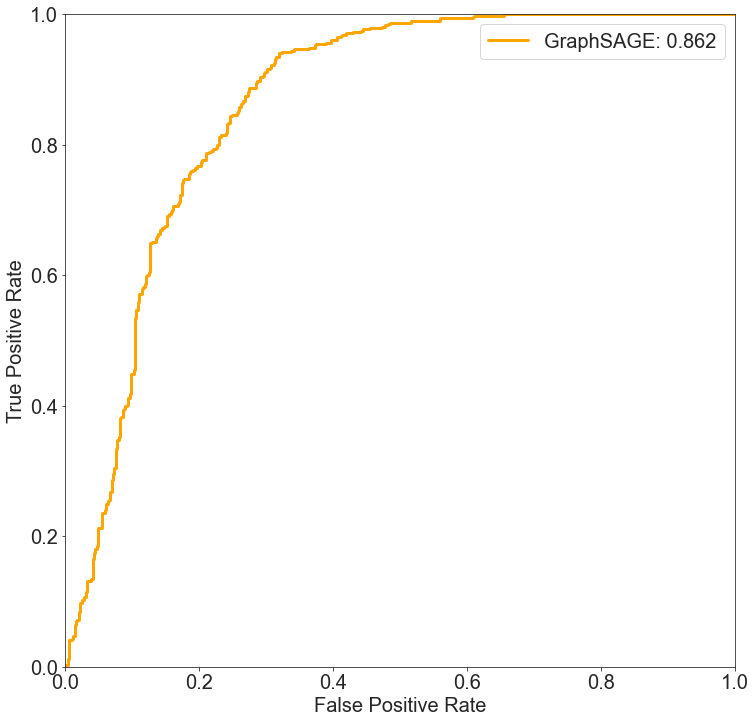

In [89]:
# Compute ROC curve and ROC area
plt.figure(figsize = (12,12))
lw = 3
# sage_fpr, sage_tpr, sage_auc, sage_ap
plt.plot(sage_fpr, sage_tpr, color='orange', label='GraphSAGE: %.3f' % sage_auc,lw = lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate',fontsize = 20)
# plt.title('ROC curve for metabolite-metabolite interaction prediction',fontsize = 20)
plt.legend(loc="lower right")
plt.legend(fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

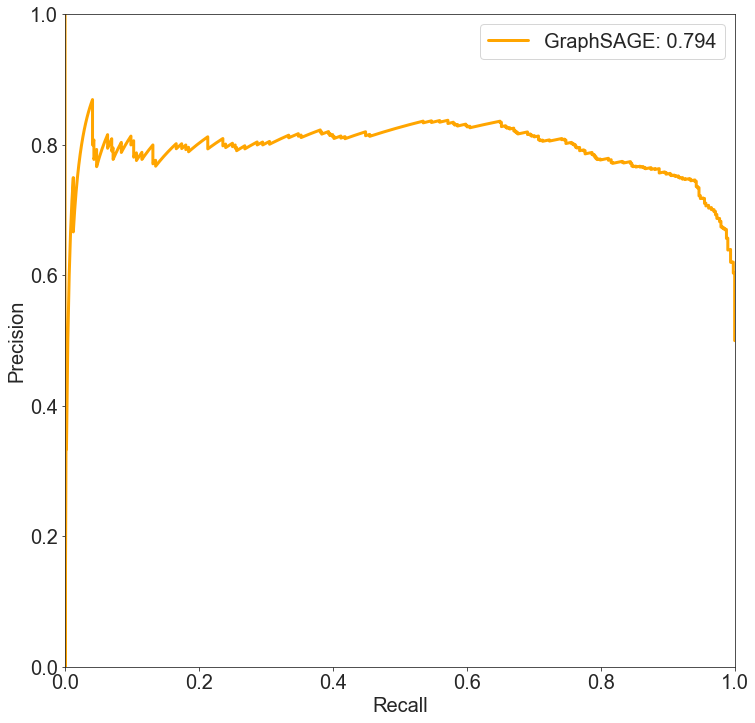

In [90]:
# Compute ROC curve and ROC area
plt.figure(figsize = (12,12))
lw = 3
plt.plot(sage_rcal, sage_prcs, color='orange', label='GraphSAGE: %.3f' % sage_ap,lw = lw)

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall',fontsize = 20)
plt.ylabel('Precision',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# plt.title('Precision-recall curve for metabolite-metabolite interaction prediction',fontsize = 20)
plt.legend(loc="lower right")
plt.legend(fontsize=20)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


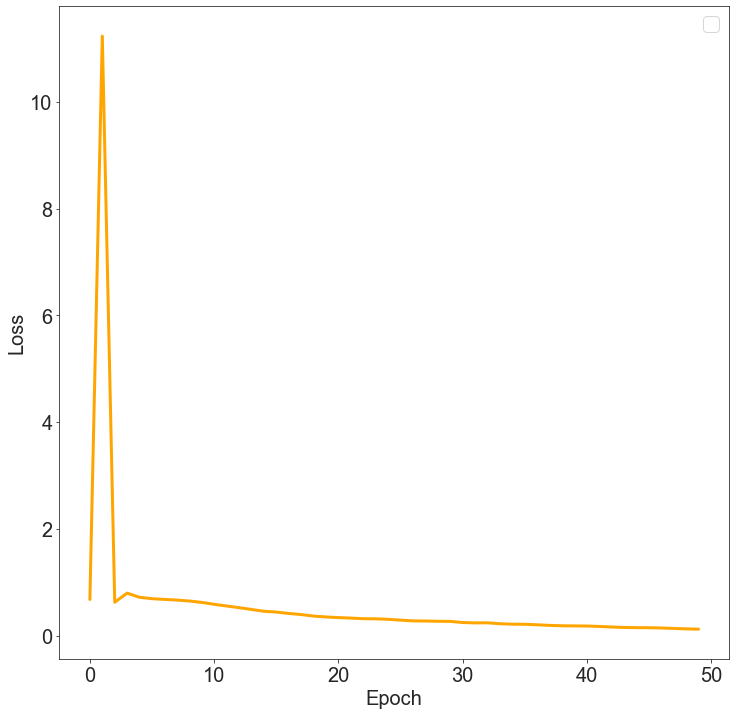

In [95]:

# Compute loss
plt.figure(figsize = (12,12))
lw = 3
# sage_fpr, sage_tpr, sage_auc, sage_ap
plt.plot(np.arange(len(all_loss)),all_loss,color='orange',lw = lw)
plt.xlabel('Epoch',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend(loc="lower right")
plt.legend(fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()